In [129]:
import numpy as np 
import matplotlib.pyplot as plt
from util import viz_grid
import torch
from torch.utils import data
from dataloader import CVD_Dataset
from desity_estimator import encode_structure,model_cvd_series,decode_structure
from util import sample_gaussian,load_model
from desity_estimator import mse_error,predict_profile

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#load training and test data
Structure_train_np = np.load('Data/Train/CVD_Structure.npy')
Condition_train_np = np.load('Data/Train/CVD_Condition.npy')
Structure_test_np = np.load('Data/Test/CVD_Structure.npy')
Condition_test_np = np.load('Data/Test/CVD_Condition.npy')
N_train = Structure_train_np.shape[0]
N_test = Structure_test_np.shape[0]
Nsamples = N_train + N_test
print(Nsamples,N_train,N_test,Structure_train_np.shape,Structure_test_np.shape)

5900 4736 1164 (4736, 20, 50, 50) (1164, 20, 50, 50)


In [37]:
#create training and test data
Structure_train = torch.tensor(Structure_train_np,dtype=torch.float32)
Condition_train = torch.tensor(Condition_train_np,dtype=torch.float32)
Structure_test = torch.tensor(Structure_test_np,dtype=torch.float32)
Condition_test = torch.tensor(Condition_test_np,dtype=torch.float32)
print(Structure_train.size(),Condition_train.size(),
      Structure_test.size(),Condition_test.size())
#training data
train_data = CVD_Dataset(structure=Structure_train,condtion=Condition_train)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1)
#test daat
test_data = CVD_Dataset(structure=Structure_test,condtion=Condition_test)
test_loader = data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=1)

torch.Size([4736, 20, 50, 50]) torch.Size([4736, 20, 4]) torch.Size([1164, 20, 50, 50]) torch.Size([1164, 20, 4])
total simulations and trajectory:  4736 20
total simulations and trajectory:  1164 20


In [38]:
model_name = 'MD_MoS2'
net_parameters = {'input_dim':7,'output_dim':72,'hidden_dim':128,'batch_size':32}

In [39]:
encoder=encode_structure(net_parameters)
decoder = decode_structure(net_parameters)
model = model_cvd_series(encoder,decoder,net_parameters,loss_type='mle',sigma=0.01)
#load moldel parameters
load_model(model,model_name)
print("sigma_type:",model.sigma_type,"loss_type:",model.loss_type,"sigma:",model.sigma)
tot_loss = np.load('checkpoints/'+model_name+'/tot_loss.npy')

sigma_type: const loss_type: mle sigma: 0.01


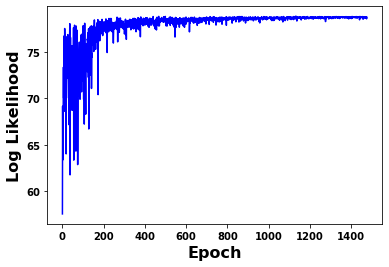

In [197]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(-1.0*np.asarray(tot_loss[300::100]),c='b')
plt.ylabel('Log Likelihood',weight='bold',fontsize=16)
plt.xlabel('Epoch',weight='bold',fontsize=16)
plt.savefig("log_likehood.png",dip=300)
plt.show()

In [132]:
batch_size = 32
#sampling
for i,batch in enumerate(test_loader):
    if batch['structure'].size(0) == batch_size:
        S_ = batch['structure']
        C_ = batch['condtion']
        Y_ = batch['P_class']
        A_ = batch['Atoms']
        #print(i, S_.size(),Y_.size(),C_.size())
        with torch.no_grad():
            model.eval()
            logit,v = predict_profile(model,C_,Y_[:,0,:],isround=False)
            if i == 0 :
                loss = mse_error(288.0*logit,S_)
                true_Y = S_
                predicted_Y = 288.0*logit
                likelihood = model.cal_likelihood(Y_[:,1:,:],logit,v)
            else:
                temp = mse_error(288.0*logit,S_)
                loss = torch.cat((loss,temp),dim=0)
                true_Y = torch.cat((true_Y,S_),dim=0)
                predicted_Y = torch.cat((predicted_Y,288.0*logit),dim=0)
                aa = model.cal_likelihood(Y_[:,1:,:],logit,v)
                likelihood = torch.cat((likelihood,aa),dim=0)
print("Test Likelihood: ",likelihood.sum(-1).sum(-1).mean())

Test Likelihood:  tensor(78.6969)


ground truth: 2H, 1T, Defect ======= Predicted 2H, 1T , Defect


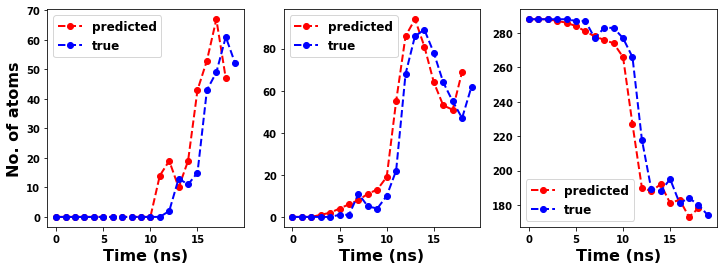

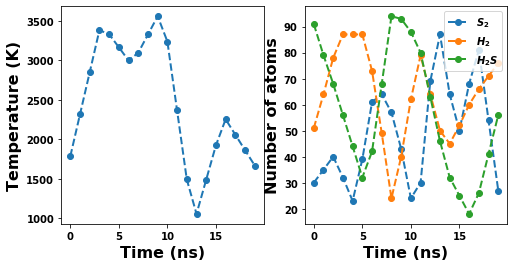

In [277]:
val=31
sample = model.sample_structure(logit,v)
print("ground truth: 2H, 1T, Defect ======= Predicted 2H, 1T , Defect")
for i in range(19):
    error = torch.abs(S_[val,i+1]-torch.round(288.0*logit[val,i]))
    #print(i+1,S_[val,i+1],torch.round(288.0*logit[val,i]),error) #288.0*logit[val,i].sum())
    #print("time= ",i+1,S_[val,i+1].numpy(),torch.round(288.0*logit[val,i]).numpy())

fig, ax = plt.subplots(1,3,figsize=(12,4))
Y_conc = torch.round(288.0*logit[val])
for i in range(3):
    ax[i].plot(Y_conc[:,i],marker='o', linestyle='dashed',
               linewidth=2, markersize=6,c='r',label='predicted')
    ax[i].plot(S_[val,:,i],marker='o', linestyle='dashed',
               linewidth=2, markersize=6,c='b',label='true')
    ax[i].legend(prop={'size': 12})
    ax[i].set_xlabel('Time (ns)',weight='bold',fontsize='16')
ax[0].set_ylabel('No. of atoms',weight='bold',fontsize='16')
plt.savefig("atomerror_profile.png",dpi=300)
plt.show()
c_legent = ['Temperature','$S_2$','$H_2$','$H_2S$']
fig, ax = plt.subplots(1,2,figsize=(8,4))
for i in range(3):
    ax[1].plot(C_[val,:,i+1],marker='o', linestyle='dashed',linewidth=2, markersize=6)
ax[0].plot(C_[val,:,0],marker='o', linestyle='dashed',linewidth=2, markersize=6)
ax[0].set_ylabel('Temperature (K)',weight='bold',fontsize='16')
ax[1].set_ylabel('Number of atoms',weight='bold',fontsize='16')
ax[0].set_xlabel('Time (ns)',weight='bold',fontsize='16')
ax[1].set_xlabel('Time (ns)',weight='bold',fontsize='16')
ax[1].legend(c_legent[1:])
plt.savefig("synthesis_profile.png",dpi=300)
plt.show()

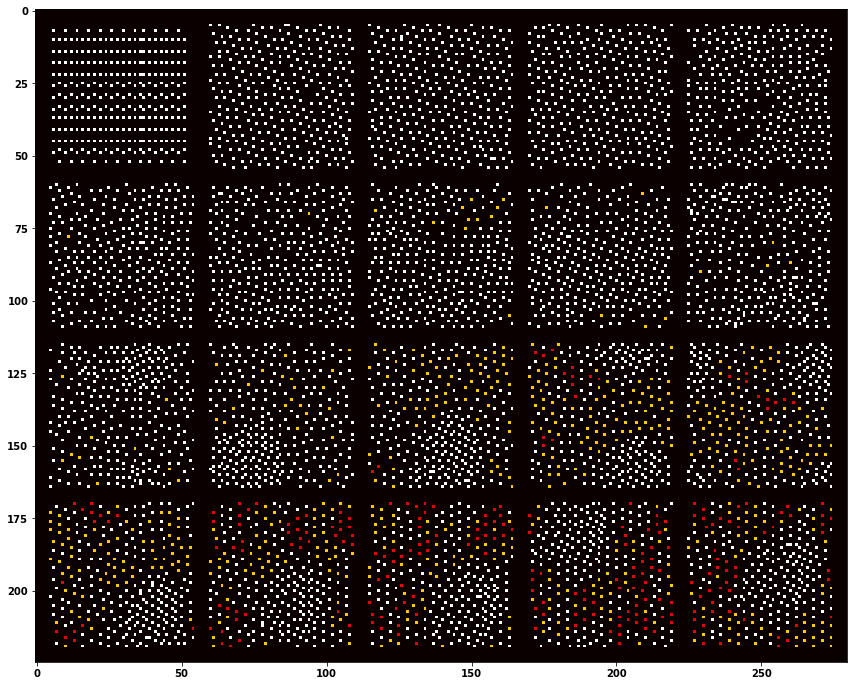

In [259]:
fig = plt.figure(figsize = (16,12)) 
ax1 = plt.subplot(111)
ax1.imshow(viz_grid(A_[val], 5),cmap='hot')
plt.savefig("atom_profile.png",dpi=300)
plt.show()

In [44]:
print("loss size: ",loss.size())
loss_mean = loss.mean(dim=0)
loss_std = loss.std(dim=0)
print(loss_mean.size(),loss_std.size())
#print("mean loss: ",torch.sqrt(loss_mean))
print(torch.sqrt(torch.max(loss.reshape(-1,3),dim=0)[0]))
#print(torch.sqrt(torch.max(loss,dim=1)[0]))
#print(torch.sqrt(torch.max(loss)))

loss size:  torch.Size([1152, 19, 3])
torch.Size([19, 3]) torch.Size([19, 3])
tensor([34.5176, 25.2688, 33.8691])


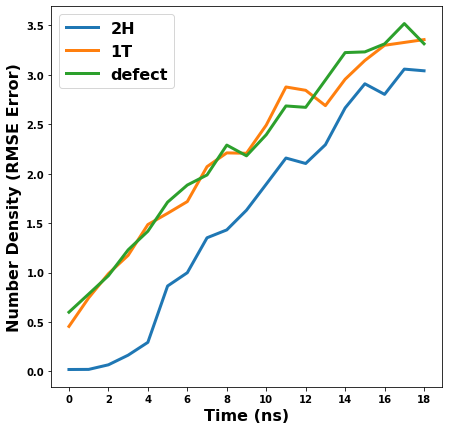

In [278]:
fig = plt.figure(figsize=(7,7))
plt.plot(torch.sqrt(loss_mean),linewidth=3)
plt.ylabel('Number Density (RMSE Error)',fontsize=16)
plt.xlabel('Time (ns)',fontsize=16)
plt.legend(['2H','1T','defect'],fontsize=16)
plt.xticks(np.arange(0,20,2))
plt.savefig("test_rmse.png",dip=300)
plt.show()

torch.Size([1152, 20, 3]) torch.Size([1152, 19, 3])
max:    tensor(9.0255) tensor(12.3948) tensor(10.2517) tensor(11.2788)
max:    tensor(14.9295) tensor(24.4433) tensor(12.3320) tensor(15.0880)
max:    tensor(17.0020) tensor(14.3603) tensor(33.8691) tensor(21.6203)
max:    tensor(20.3808) tensor(24.5529) tensor(17.7509) tensor(22.2538)


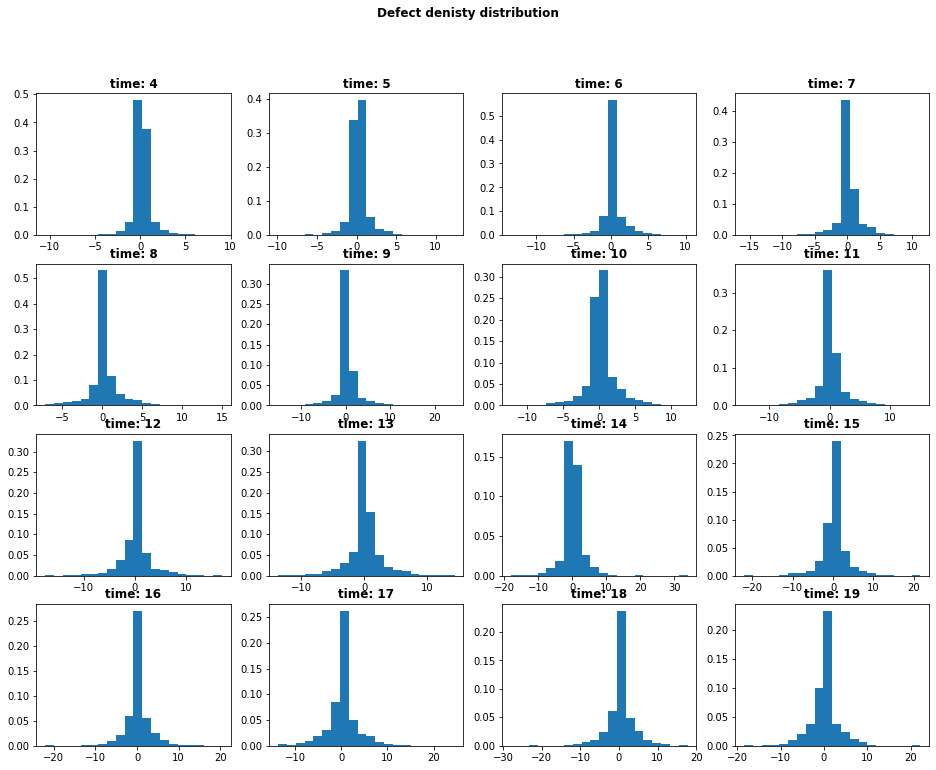

In [53]:
val = 2
fig, ax = plt.subplots(4,4,figsize=(16,12))
print(true_Y.size(),predicted_Y.size())
for count,i_val in enumerate(range(3,19,4)):
    prob_a = true_Y[:,i_val+1,val] - predicted_Y[:,i_val  ,val]
    prob_b = true_Y[:,i_val+2,val] - predicted_Y[:,i_val+1,val]
    prob_c = true_Y[:,i_val+3,val] - predicted_Y[:,i_val+2,val]
    prob_d = true_Y[:,i_val+4,val] - predicted_Y[:,i_val+3,val]
    ax[count,0].hist(prob_a,bins=20,density=True)
    ax[count,1].hist(prob_b,bins=20,density=True)
    ax[count,2].hist(prob_c,bins=20,density=True)
    ax[count,3].hist(prob_d,bins=20,density=True)
    for j in range(4):
        ax[count,j].set_title("time: "+str(i_val+j+1),fontweight='bold',fontsize=12)
    print("max:   ",torch.max(prob_a),torch.max(prob_b),torch.max(prob_c),torch.max(prob_d))
    #print("mean:  ",torch.mean(prob_a),torch.mean(prob_b),torch.mean(prob_c),torch.mean(prob_d))
    #print("std:   ",torch.std(prob_a),torch.std(prob_b),torch.std(prob_c),torch.std(prob_d))
fig.suptitle("Defect denisty distribution",fontweight='bold',fontsize=12)
plt.savefig("pdf_defect.png")
plt.show()

torch.Size([1152, 20, 3]) torch.Size([1152, 19, 3]) torch.Size([1152, 3]) torch.Size([1152, 3]) torch.Size([1152, 19, 3])


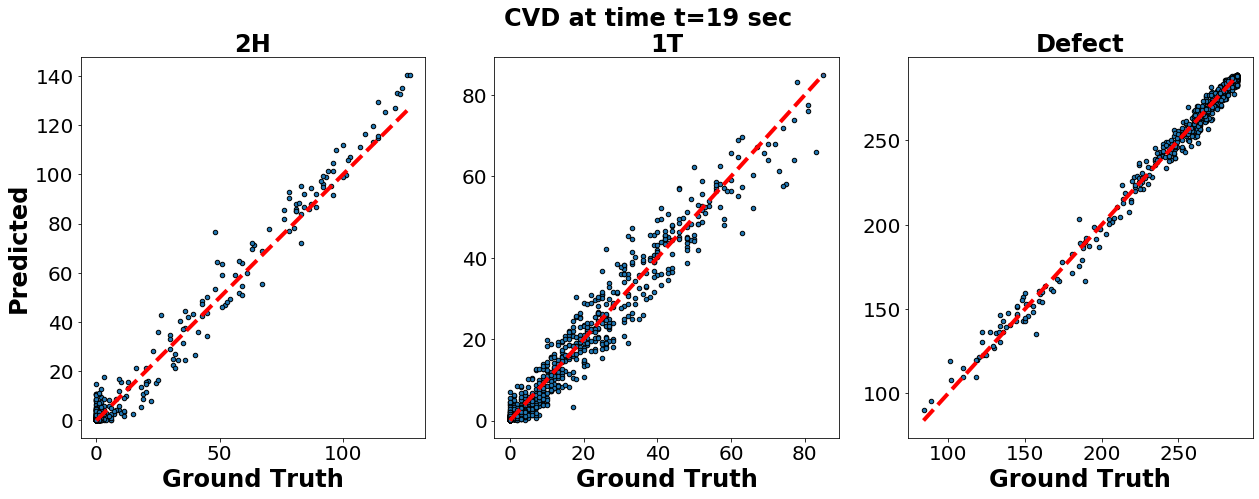

In [47]:
val=18
zz = true_Y[:,1:,:]
xx = zz[:,val,:]
yy = predicted_Y[:,val,:]

print(true_Y.size(),predicted_Y.size(),xx.size(),yy.size(),zz.size())
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,7))

ax1.scatter(xx[:,0], yy[:,0], edgecolors=(0, 0, 0),s=20)
ax1.plot([xx[:,0].min(), xx[:,0].max()], [xx[:,0].min(),xx[:,0].max()], 'r--', lw=4)
ax1.set_xlabel('Ground Truth',fontweight='bold',fontsize=24)
ax1.set_ylabel('Predicted',fontweight='bold',fontsize=24)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)

ax2.scatter(xx[:,1], yy[:,1], edgecolors=(0, 0, 0),s=20)
ax2.plot([xx[:,1].min(), xx[:,1].max()], [xx[:,1].min(),xx[:,1].max()], 'r--', lw=4)
ax2.set_xlabel('Ground Truth',fontweight='bold',fontsize=24)
#ax2.set_ylabel('Predicted',fontweight='bold',fontsize=24)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 20)

ax3.scatter(xx[:,2], yy[:,2], edgecolors=(0, 0, 0),s=20)
ax3.plot([xx[:,2].min(), xx[:,2].max()], [xx[:,2].min(),xx[:,2].max()], 'r--', lw=4)
ax3.set_xlabel('Ground Truth',fontweight='bold',fontsize=24)
#ax3.set_ylabel('Predicted',fontweight='bold',fontsize=24)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 20)

fig.suptitle("CVD at time t="+str(val+1)+" sec",fontweight='bold',fontsize=24)
ax1.set_title("2H",fontweight='bold',fontsize=24)
ax2.set_title("1T",fontweight='bold',fontsize=24)
ax3.set_title("Defect",fontweight='bold',fontsize=24)
plt.savefig("compair_test.png")
plt.show()

2H mean, std and max:  -0.52096486 3.0027497 14.214883 -28.70169
1T mean, std and max:  0.045843225 3.3425937 17.045036 -16.142746
Defect mean, std and max:  0.13687222 3.3127034 22.253845 -18.424988


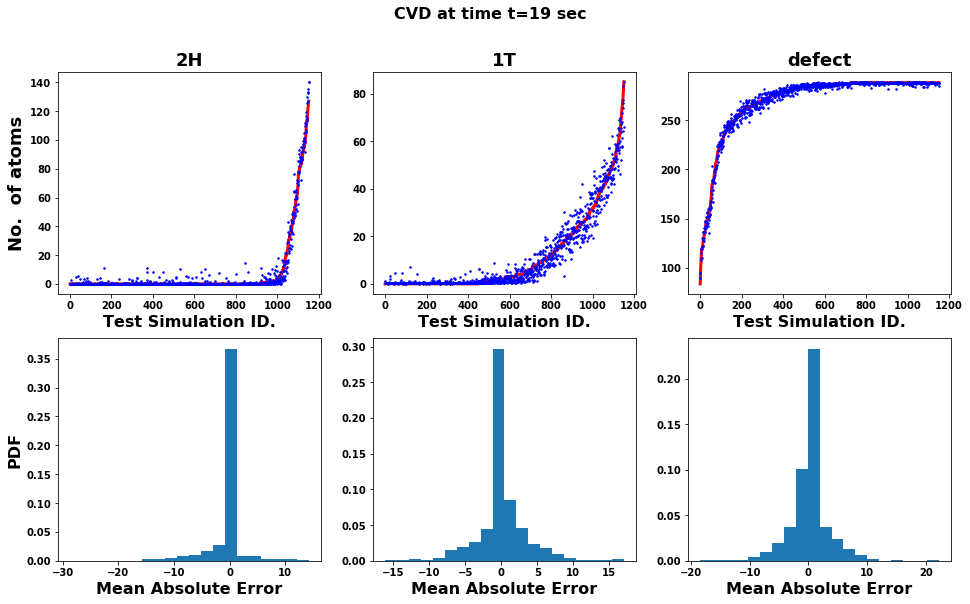

In [214]:
val=18
zz = true_Y[:,1:,:]
xx = zz[:,val,:]
yy = predicted_Y[:,val,:]
fig, ax = plt.subplots(2,3,figsize=(16,9))
fig.suptitle("CVD at time t="+str(val+1)+" sec",fontweight='bold',fontsize=16)

ytest = xx[:,0].numpy()
y_pred =yy[:,0].numpy()
diff_xy = ytest-y_pred
xxdummy=range(len(ytest))
dataorder = np.argsort(ytest)
ax[0,0].plot(xxdummy, ytest[dataorder], 'r-', linewidth=3, label=u'True Value')
ax[0,0].plot(xxdummy, y_pred[dataorder], 'b.', markersize=3)
ax[1,0].hist(diff_xy, bins=20,density=True)
ax[0,0].set_title("2H",fontweight='bold',fontsize=18)
print("2H mean, std and max: ",np.mean(diff_xy),np.std(diff_xy),
      np.max(diff_xy),np.min(diff_xy))

ytest = xx[:,1].numpy()
y_pred =yy[:,1].numpy()
diff_xy = ytest-y_pred
xxdummy=range(len(ytest))
dataorder = np.argsort(ytest)
ax[0,1].plot(xxdummy, ytest[dataorder], 'r-', linewidth=3, label=u'True Value')
ax[0,1].plot(xxdummy, y_pred[dataorder], 'b.', markersize=3)
ax[1,1].hist(diff_xy, bins=20,density=True)
ax[0,1].set_title("1T",fontweight='bold',fontsize=18)
print("1T mean, std and max: ",np.mean(diff_xy),np.std(diff_xy),
      np.max(diff_xy),np.min(diff_xy))

ytest = xx[:,2].numpy()
y_pred =yy[:,2].numpy()
diff_xy = ytest-y_pred
xxdummy=range(len(ytest))
dataorder = np.argsort(ytest)
ax[0,2].plot(xxdummy, ytest[dataorder], 'r-', linewidth=3, label=u'True Value')
ax[0,2].plot(xxdummy, y_pred[dataorder], 'b.', markersize=3)
ax[1,2].hist(diff_xy, bins=20,density=True)
ax[0,2].set_title("defect",fontweight='bold',fontsize=18)
ax[1,0].set_ylabel('PDF',fontsize=16)
ax[0,0].set_ylabel('No.  of atoms',fontsize=18)

ax[0,0].set_xlabel('Test Simulation ID.',fontsize=16)
ax[0,1].set_xlabel('Test Simulation ID.',fontsize=16)
ax[0,2].set_xlabel('Test Simulation ID.',fontsize=16)
ax[1,0].set_xlabel('Mean Absolute Error',fontsize=16)
ax[1,1].set_xlabel('Mean Absolute Error',fontsize=16)
ax[1,2].set_xlabel('Mean Absolute Error',fontsize=16)
print("Defect mean, std and max: ",np.mean(diff_xy),np.std(diff_xy),
      np.max(diff_xy),np.min(diff_xy))
plt.savefig("compair_test_19.png")
plt.show()

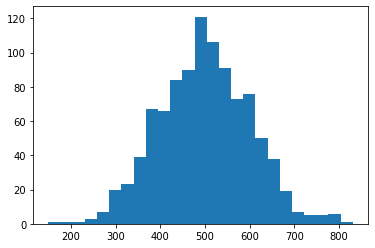

In [72]:
pp = np.random.normal(500, 100, 1000)
plt.hist(pp,bins=25)
plt.show()

In [117]:
a=15
b=2
diff_C = torch.abs(C_[:,1:,:]-C_[:,0:-1,:])
print(diff_C.shape)
diff_C = diff_C.reshape(-1,4)
print(diff_C.shape)
#print(C_[a,1:,b])
print(diff_C.mean(dim=0))
print(diff_C.std(dim=0))

torch.Size([32, 19, 4])
torch.Size([608, 4])
tensor([227.1957,   7.0938,   7.1875,   7.8026])
tensor([186.2438,   6.7626,   6.9700,   7.6335])
